In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from datetime import datetime
import math
from operator import truediv
import os
import pickle
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report, cohen_kappa_score, f1_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn.modules.loss import _Loss
import spectral
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/indian-pines-hyperspectral-dataset/indianpinearray.npy
/kaggle/input/indian-pines-hyperspectral-dataset/IPgt.npy


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
seed = 3

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(seed)

torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
test_ratio = 0.8
val_and_test_ratio = 0.5
windowSize = 25
batch_size = 64
no_of_PCA_components = 30

# model architecture
A, B, C, D = 64, 32, 16, 16

# EM Iterations
em_iters = 2

# PCA Componenets
pca_components = 30

# Epochs
epochs = 10

# Learning rate
lr = 3e-3

# Weight Decay
wd = 2e-7

# Test Intervals
test_intervals = 1

# Log Interval
log_interval = 10

# No. of classes
num_class = 16



def loadData():
    images = np.load('/kaggle/input/indian-pines-hyperspectral-dataset/indianpinearray.npy')
    labels = np.load("/kaggle/input/indian-pines-hyperspectral-dataset/IPgt.npy")
    return images, labels


def applyPCA(X, n_components=no_of_PCA_components, seed=seed):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=n_components, whiten=True, random_state=seed)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], n_components))
    return newX

def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2*margin, X.shape[1] + 2*margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX [x_offset : X.shape[0] + x_offset, y_offset : X.shape[1] + y_offset, :] = X
    return newX

def createImageCubes(X, y, windowSize=windowSize, removeZeroLabels=True):
    margin = int((windowSize-1)/2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    
    patchesData = np.zeros((X.shape[0]*X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin: r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex += 1
    
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels > 0, :, :, :]
        patchesLabels = patchesLabels[patchesLabels > 0]
        patchesLabels -= 1
    
    
    patchesData = patchesData.transpose((0, 3, 1, 2))
    
    return patchesData, patchesLabels

def dataSplit(X, y, val_and_test_ratio=val_and_test_ratio, test_ratio=test_ratio, random_state=seed):
    X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(X, y, test_size=val_and_test_ratio, random_state=random_state, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_val_and_test, y_val_and_test, test_size=test_ratio, random_state=random_state, stratify=y_val_and_test)
    return X_train, y_train, X_val, y_val, X_test, y_test


def convertToDataloader(X_train, y_train, X_val, y_val, X_test, y_test, batch_size=batch_size, K=no_of_PCA_components):

    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_val = torch.Tensor(X_val)
    y_val = torch.Tensor(y_val)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)

    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    val_dataset = torch.utils.data.TensorDataset(X_val, y_val)
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
    test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

    return train_dataloader, val_dataloader, test_dataloader

X, y = loadData()
X.shape, y.shape

X = applyPCA(X)
X.shape

X, y = createImageCubes(X, y)
X.shape, y.shape
X_train, y_train, X_val, y_val, X_test, y_test = dataSplit(X, y)
print("X Train: ", X_train.shape)
print("Y Train: ", y_train.shape)
print("X Val: ", X_val.shape)
print("Y Val: ", y_val.shape)
print("X Test: ", X_test.shape)
print("Y Test: ", y_test.shape)
train_loader, val_loader, test_loader = convertToDataloader(X_train, y_train, X_val, y_val, X_test, y_test)
dataloaders = {'train': train_loader, 'valid': val_loader,'test': test_loader}

class PrimaryCaps(nn.Module):
    
    def __init__(self, A=32, B=32, K=1, P=4, stride=1):
        super(PrimaryCaps, self).__init__()
        self.pose = nn.Conv2d(in_channels=A, out_channels=B*P*P,
                            kernel_size=K, stride=stride, bias=True)
        self.a = nn.Conv2d(in_channels=A, out_channels=B,
                            kernel_size=K, stride=stride, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        p = self.pose(x)
        a = self.a(x)
        a = self.sigmoid(a)
        out = torch.cat([p, a], dim=1)
        out = out.permute(0, 2, 3, 1)
        return out

class ConvCaps(nn.Module):

    def __init__(self, B=32, C=32, K=3, P=4, stride=2, iters=3,
                 coor_add=False, w_shared=False):
        super(ConvCaps, self).__init__()
        self.B = B
        self.C = C
        self.K = K
        self.P = P
        self.psize = P*P
        self.stride = stride
        self.iters = iters
        self.coor_add = coor_add
        self.w_shared = w_shared
        self.eps = 1e-8
        self._lambda = 1e-03
        self.ln_2pi = torch.cuda.FloatTensor(1).fill_(math.log(2*math.pi))

        self.beta_u = nn.Parameter(torch.zeros(C))
        self.beta_a = nn.Parameter(torch.zeros(C))

        self.weights = nn.Parameter(torch.randn(1, K*K*B, C, P, P))
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=2)

    def m_step(self, a_in, r, v, eps, b, B, C, psize):

        r = r * a_in
        r = r / (r.sum(dim=2, keepdim=True) + eps)
        r_sum = r.sum(dim=1, keepdim=True)
        coeff = r / (r_sum + eps)
        coeff = coeff.view(b, B, C, 1)

        mu = torch.sum(coeff * v, dim=1, keepdim=True)
        sigma_sq = torch.sum(coeff * (v - mu)**2, dim=1, keepdim=True) + eps

        r_sum = r_sum.view(b, C, 1)
        sigma_sq = sigma_sq.view(b, C, psize)
        cost_h = (self.beta_u.view(C, 1) + torch.log(sigma_sq.sqrt())) * r_sum

        a_out = self.sigmoid(self._lambda*(self.beta_a - cost_h.sum(dim=2)))
        sigma_sq = sigma_sq.view(b, 1, C, psize)

        return a_out, mu, sigma_sq

    def e_step(self, mu, sigma_sq, a_out, v, eps, b, C):

        ln_p_j_h = -1. * (v - mu)**2 / (2 * sigma_sq) \
                    - torch.log(sigma_sq.sqrt()) \
                    - 0.5*self.ln_2pi

        ln_ap = ln_p_j_h.sum(dim=3) + torch.log(a_out.view(b, 1, C))
        r = self.softmax(ln_ap)
        return r

    def caps_em_routing(self, v, a_in, C, eps):

        b, B, c, psize = v.shape
        assert c == C
        assert (b, B, 1) == a_in.shape

        r = torch.cuda.FloatTensor(b, B, C).fill_(1./C)
        for iter_ in range(self.iters):
            a_out, mu, sigma_sq = self.m_step(a_in, r, v, eps, b, B, C, psize)
            if iter_ < self.iters - 1:
                r = self.e_step(mu, sigma_sq, a_out, v, eps, b, C)

        return mu, a_out

    def add_pathes(self, x, B, K, psize, stride):

        b, h, w, c = x.shape
        assert h == w
        assert c == B*(psize+1)
        oh = ow = int(((h - K )/stride)+ 1)
        idxs = [[(h_idx + k_idx) \
                for k_idx in range(0, K)] \
                for h_idx in range(0, h - K + 1, stride)]
        x = x[:, idxs, :, :]
        x = x[:, :, :, idxs, :]
        x = x.permute(0, 1, 3, 2, 4, 5).contiguous()
        return x, oh, ow

    def transform_view(self, x, w, C, P, w_shared=False):

        b, B, psize = x.shape
        assert psize == P*P

        x = x.view(b, B, 1, P, P)
        if w_shared:
            hw = int(B / w.size(1))
            w = w.repeat(1, hw, 1, 1, 1)

        w = w.repeat(b, 1, 1, 1, 1)
        x = x.repeat(1, 1, C, 1, 1)
        v = torch.matmul(x, w)
        v = v.view(b, B, C, P*P)
        return v

    def add_coord(self, v, b, h, w, B, C, psize):
        
        assert h == w
        v = v.view(b, h, w, B, C, psize)
        coor = torch.arange(h, dtype=torch.float32) / h
        coor_h = torch.cuda.FloatTensor(1, h, 1, 1, 1, self.psize).fill_(0.)
        coor_w = torch.cuda.FloatTensor(1, 1, w, 1, 1, self.psize).fill_(0.)
        coor_h[0, :, 0, 0, 0, 0] = coor
        coor_w[0, 0, :, 0, 0, 1] = coor
        v = v + coor_h + coor_w
        v = v.view(b, h*w*B, C, psize)
        return v

    def forward(self, x):
        b, h, w, c = x.shape
        if not self.w_shared:
            x, oh, ow = self.add_pathes(x, self.B, self.K, self.psize, self.stride)

            p_in = x[:, :, :, :, :, :self.B*self.psize].contiguous()
            a_in = x[:, :, :, :, :, self.B*self.psize:].contiguous()
            p_in = p_in.view(b*oh*ow, self.K*self.K*self.B, self.psize)
            a_in = a_in.view(b*oh*ow, self.K*self.K*self.B, 1)
            v = self.transform_view(p_in, self.weights, self.C, self.P)

            p_out, a_out = self.caps_em_routing(v, a_in, self.C, self.eps)
            p_out = p_out.view(b, oh, ow, self.C*self.psize)
            a_out = a_out.view(b, oh, ow, self.C)
            out = torch.cat([p_out, a_out], dim=3)
        else:
            assert c == self.B*(self.psize+1)
            assert 1 == self.K
            assert 1 == self.stride
            p_in = x[:, :, :, :self.B*self.psize].contiguous()
            p_in = p_in.view(b, h*w*self.B, self.psize)
            a_in = x[:, :, :, self.B*self.psize:].contiguous()
            a_in = a_in.view(b, h*w*self.B, 1)

            v = self.transform_view(p_in, self.weights, self.C, self.P, self.w_shared)

            if self.coor_add:
                v = self.add_coord(v, b, h, w, self.B, self.C, self.psize)

            _, out = self.caps_em_routing(v, a_in, self.C, self.eps)

        return out
    

class CapsNet(nn.Module):

    def __init__(self, A=32, B=32, C=32, D=32, E=10, K=3, P=4, iters=3):
        super(CapsNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=pca_components, out_channels=A,
                               kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=A, eps=0.001,
                                 momentum=0.1, affine=True)
        self.relu1 = nn.ReLU(inplace=False)
        self.primary_caps = PrimaryCaps(A, B, 1, P, stride=1)
        self.conv_caps1 = ConvCaps(B, C, K, P, stride=2, iters=iters)
        self.conv_caps2 = ConvCaps(C, D, K, P, stride=1, iters=iters)
        self.class_caps = ConvCaps(D, E, 1, P, stride=1, iters=iters,
                                        coor_add=True, w_shared=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.primary_caps(x)
        x = self.conv_caps1(x)
        x = self.conv_caps2(x)
        x = self.class_caps(x)
        return x
    
class ContrastiveLoss(_Loss):

    def __init__(self, m_min=0.2, m_max=0.9, num_class=16):
        super(ContrastiveLoss, self).__init__()
        self.m_min = m_min
        self.m_max = m_max
        self.num_class = num_class

    def forward(self, x, target, r):
        b, E = x.shape
        assert E == self.num_class
        margin = self.m_min + (self.m_max - self.m_min)*r

        at = torch.cuda.FloatTensor(b).fill_(0)
        for i, a in enumerate(target):
            lb = int(a.item())
            at[i] = x[i][lb]
        at = at.view(b, 1).repeat(1, E)

        zeros = x.new_zeros(x.shape)
        loss = torch.max(margin - (at - x), zeros)
        loss = loss**2
        loss = loss.sum() / b - margin**2

        return loss
    
train_loader = dataloaders['train']
valid_loader = dataloaders['valid']
test_loader = dataloaders['test']

def accuracy(output, target):
    y_pred = output.argmax(dim=1).float()
    res = accuracy_score(target.to('cpu'), y_pred.to('cpu')) * 100
    return res


def exp_lr_decay(optimizer, global_step, init_lr = 3e-3, decay_steps = 20000,
                                        decay_rate = 0.96, lr_clip = 3e-3 ,staircase=False):
        
    if staircase:
        lr = (init_lr * decay_rate**(global_step // decay_steps)) 
    else:
        lr = (init_lr * decay_rate**(global_step / decay_steps)) 
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
        
        
        
class AverageMeter(object):

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def train(train_loader, model, criterion, optimizer, epoch, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()

    model.train()
    train_len = len(train_loader)
    epoch_acc = 0
    end = time.time()

    for batch_idx, (data, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        r = (1.*batch_idx + (epoch-1)*train_len) / (epochs*train_len)
        loss = criterion(output, target, r)
        acc = accuracy(output, target)
        
        global_step = (batch_idx+1) + (epoch - 1) * len(train_loader) 
        exp_lr_decay(optimizer=optimizer, global_step=global_step)
        
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()

        epoch_acc += acc
        if batch_idx % log_interval == 0:
            print('Train Epoch: {}\t[{}/{} ({:.0f}%)]\t'
                  'Loss: {:.6f}\tAccuracy: {:.6f}\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader),
                  loss.item(), acc,
                  batch_time=batch_time, data_time=data_time))
            
    return epoch_acc

def test(test_loader, model, criterion, device, test=False):
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target, r=1).item()
            acc += accuracy(output, target)

    test_loss /= test_len
    acc /= test_len
    if test:
        print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))
    else:
        print('\nVal set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
            test_loss, acc))

    return test_loss, acc

model = CapsNet(A=A, B=B, C=C, D=D, E=num_class,
                    iters=em_iters).to(device)

def model_summary(model):
    total_param = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            num_param = np.prod(param.size())
            if param.dim() > 1:
                print(name, ':', 'x'.join(str(x) for x in list(param.size())), '=', num_param)
            else:
                print(name, ':', num_param)
            total_param += num_param
    print("\n Total Trainable Parameters: ", total_param)

model_summary(model)

criterion = ContrastiveLoss(num_class=num_class, m_min=0.2, m_max=0.5)
optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=wd)

veri = []

# Trainging Loop

training_start_time = time.time()

best_acc = test(valid_loader, model, criterion, device)[1]

for epoch in range(1, epochs + 1):
    acc = train(train_loader, model, criterion, optimizer, epoch, device)
    acc /= len(train_loader)

    current_acc = test(valid_loader, model, criterion, device)[1]
    
    veri.append(current_acc)
    
    if current_acc > best_acc:
        best_acc = current_acc
        print("-------------------- HIGHEST ACCURACY ---------------------------")
        torch.save(model.state_dict(), './model.pth')

        
training_stop_time = time.time()

best_acc = max(best_acc, test(valid_loader, model, criterion, device)[0])
print('\n\nBest validation accuracy: {:.6f}'.format(best_acc))

print('\n Total time taken in seconds: ', training_stop_time - training_start_time)

cuda:0
X Train:  (5124, 30, 25, 25)
Y Train:  (5124,)
X Val:  (1025, 30, 25, 25)
Y Val:  (1025,)
X Test:  (4100, 30, 25, 25)
Y Test:  (4100,)
conv1.weight : 64x30x5x5 = 48000
conv1.bias : 64
bn1.weight : 64
bn1.bias : 64
primary_caps.pose.weight : 512x64x1x1 = 32768
primary_caps.pose.bias : 512
primary_caps.a.weight : 32x64x1x1 = 2048
primary_caps.a.bias : 32
conv_caps1.beta_u : 16
conv_caps1.beta_a : 16
conv_caps1.weights : 1x288x16x4x4 = 73728
conv_caps2.beta_u : 16
conv_caps2.beta_a : 16
conv_caps2.weights : 1x144x16x4x4 = 36864
class_caps.beta_u : 16
class_caps.beta_a : 16
class_caps.weights : 1x16x16x4x4 = 4096

 Total Trainable Parameters:  198336

Val set: Average loss: 4.828254, Accuracy: 0.919118 

Train Epoch: 1	[0/5124 (0%)]	Loss: 1.088566	Accuracy: 3.125000	Time 0.914 (0.914)	Data 0.004 (0.004)
Train Epoch: 1	[640/5124 (12%)]	Loss: 0.376664	Accuracy: 28.125000	Time 0.591 (0.588)	Data 0.002 (0.003)
Train Epoch: 1	[1280/5124 (25%)]	Loss: 0.175420	Accuracy: 73.437500	Time 0.59

# Vizualizacion TEST 


Test set: Average loss: 0.041815, Accuracy: 98.701923 


Test set: Average loss: 0.041815, Accuracy: 98.701923 

------------------------ CONFUSION MATRIX -------------------------
[[ 15   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 567   4   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0 332   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  94   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   1   0 192   0   0   0   0   0   1   0   0   0   0   0]
 [  0   0   0   0   0 292   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0  11   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0 191   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   1   0   0   7   0   0   0   0   0   0   0]
 [  2  14   0   0   0   0   0   0   0 373   0   0   0   0   0   0]
 [  0   7   0   0   0   2   0   0   0   0 974   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0 238   0   0   0   0]
 [  0   0   0 

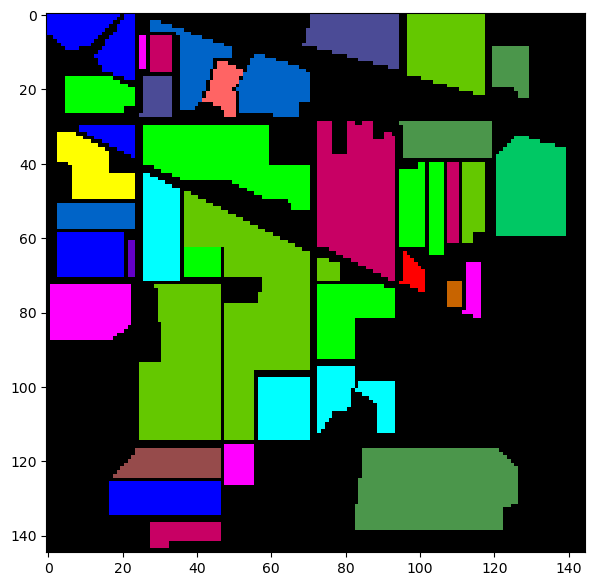

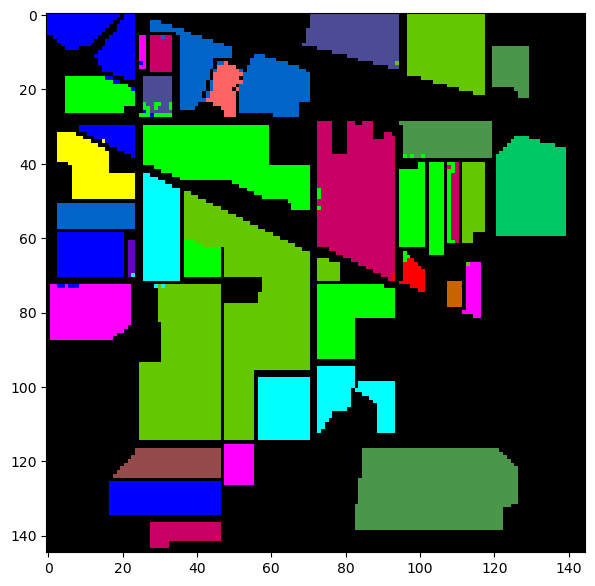

In [5]:
model = CapsNet(A=A, B=B, C=C, D=D, E=num_class, iters=em_iters).to(device)
model.load_state_dict(torch.load('./model.pth'))
test(test_loader, model, criterion, device, test=True);

def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

def report(model=model, test_loader=test_loader, criterion=criterion, device=device):

    y_pred = []
    y_test = []
    model.eval()
    test_loss = 0
    acc = 0
    test_len = len(test_loader)
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.to(device))
            y_pred.extend(output.argmax(dim=1).float().tolist())
            y_test.extend(target.tolist())

    target_labels = ['0', '1', '2', '3', '4', '5', '6', '7', 
            '8', '9', '10', '11', '12', '13', '14', '15']

    classificationReport = classification_report(y_test, y_pred, target_names=target_labels)
    confusionMatrix = confusion_matrix(y_test, y_pred)
    oa = accuracy_score(y_test, y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusionMatrix)
    kappa = cohen_kappa_score(y_test, y_pred)
    f_measure = f1_score(y_test, y_pred, average='macro')
    test_loss, acc = test(test_loader, model, criterion, device, test=True)

    
    
    
    print("------------------------ CONFUSION MATRIX -------------------------")
    print(confusionMatrix)

    print("\n\n---------------------- CLASSIFICATION REPORT ----------------------")
    print(classificationReport)

    print('\n\n------------------------ OVERALL ACCURACY -------------------------')
    print(oa)

    print('\n\n------------------------ AVERAGE ACCURACY -------------------------')
    print(aa)

    print('\n\n--------------------------- KAPPA SCORE ---------------------------')
    print(kappa)
    
    print('\n\n--------------------------- F-Measure ---------------------------')
    print(f_measure)

    print('\n\n-------------------------- TEST ACCURACY --------------------------')
    print('\nTest set: Average loss: {:.6f}, Accuracy: {:.6f} \n'.format(
        test_loss, acc))

report()


X,y = loadData()
X = applyPCA(X)
X = padWithZeros(X, windowSize//2)


def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index + windowSize)
    width_slice = slice(width_index, width_index + windowSize)
    patch = data[height_slice, width_slice, :]
    return patch

height,width = y.shape[0],y.shape[1]
outputs = np.zeros((height,width))
model.eval()
with torch.no_grad():
  for i in range(height):
      for j in range(width):
          target = int(y[i,j])
          if target == 0 :
              continue
          else :
              image_patch=Patch(X,i,j)
              X_test_image = image_patch.transpose(2,0,1)
              X_test_image = X_test_image.reshape(1,X_test_image.shape[0],X_test_image.shape[1], X_test_image.shape[2])
              X_test_image = torch.Tensor(X_test_image).to(device)
              pred = model(X_test_image)
              pred = pred.cpu().numpy()
              pred = np.argmax(pred, axis=-1)
              outputs[i][j] = pred[0]+1
            
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [6]:
ortalama = np.mean(veri)
standart_sapma = np.std(veri)
print("Veri kümesinin ortalaması:", ortalama)
print("Veri kümesinin standart sapması:", standart_sapma)

Veri kümesinin ortalaması: 97.78492647058823
Veri kümesinin standart sapması: 1.4760067912425452


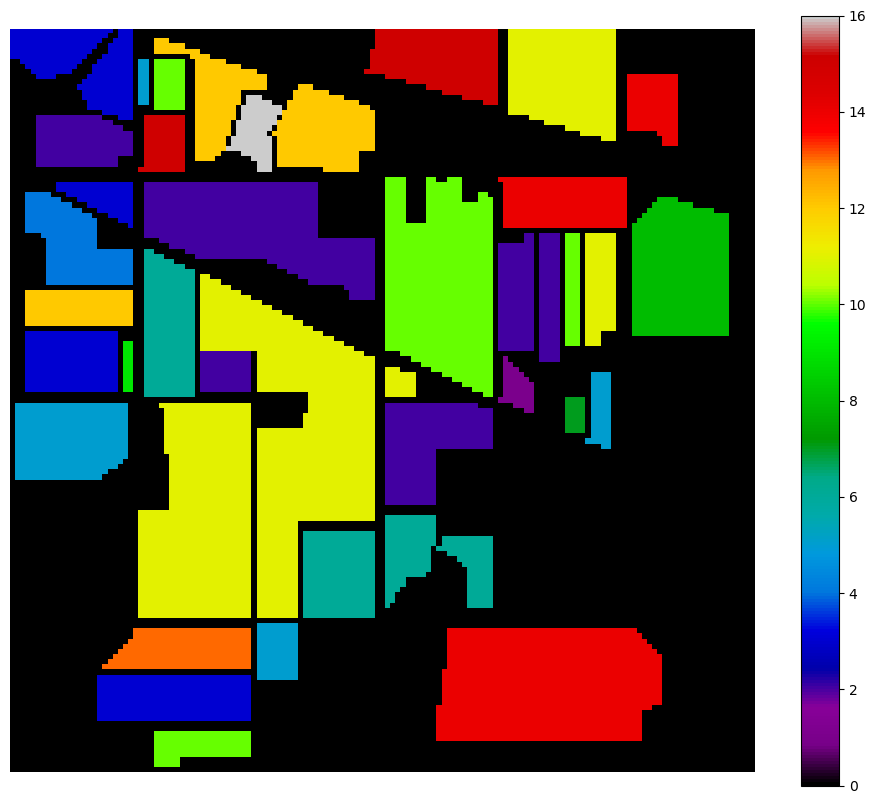

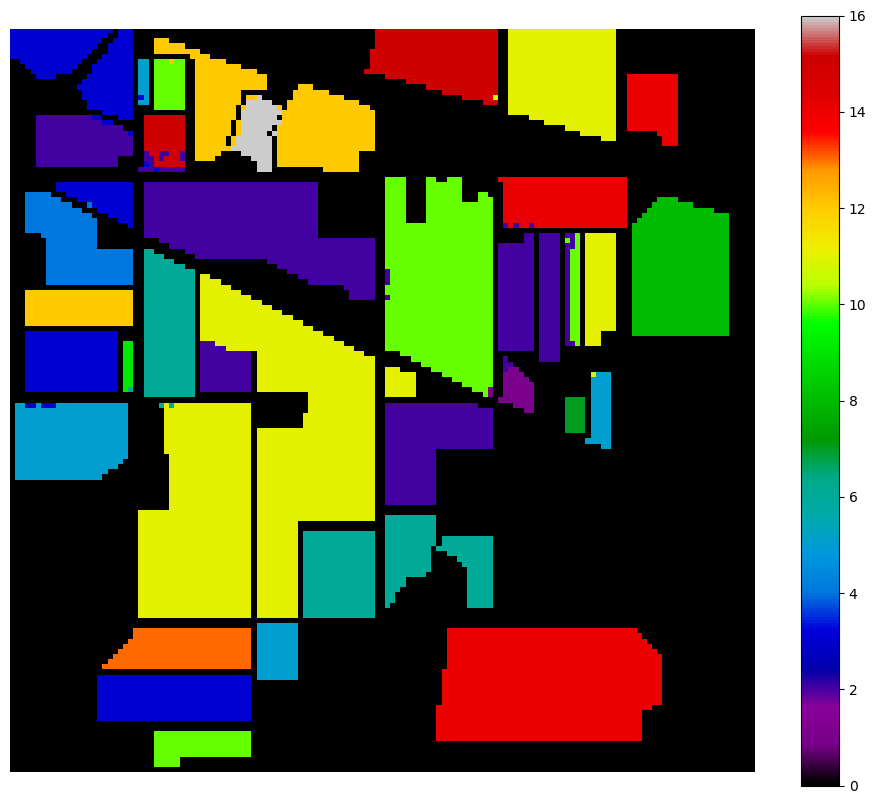

In [7]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()
plot_data(y)
plot_data(outputs.astype(int))